In [1]:
from read_simulation_data.get_foreground_variable import get_foreground_variable
from read_simulation_data.get_background_variable import get_background_variable
from read_simulation_data.get_info import get_info

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import astropy.units as u

In [142]:
def central_z(var, dz):
    #rolling the variables and making sure top and bottom boundaries are removed
    positive_var = np.roll(var, -1, axis=0)
    negative_var = np.roll(var, 1, axis=0)

    
    central = (positive_var-negative_var)/(2*dz)
    # Set endpoints to zero
    central[0] = 0
    central[1] = 0
    central[2] = 0
    central[-3] = 0
    central[-2] = 0
    central[-1] = 0
    return central

def upwind_z(var, v, dz):
    #rolling the variables and making sure top and bottom boundaries are removed
    positive_var = np.roll(var, -1, axis=0)
    negative_var = np.roll(var, 1, axis=0)

    #calculating upwind scheme for positive velocity
    upwind = (var - negative_var)/dz

    #checking if velocity<0 at any point in the grid
    x = np.where(v<0)

    #checking if any negative values occured and using the upwind scheme for negative velocity
    #at the points of negative velocity values
    if len(x) != 0:
        for index in range(len(x)):
            x_index = x[index]
            upwind[x_index] = (positive_var[x_index] - var[x_index])/dz

    # Set endpoints to zero
    upwind[0] = 0
    upwind[1] = 0
    upwind[2] = 0
    upwind[-3] = 0
    upwind[-2] = 0
    upwind[-1] = 0
    return upwind

def central_second_z(var, dz):
    #rolling the variables and making sure top and bottom boundaries are removed
    positive_var = np.roll(var, -1, axis=0)
    negative_var = np.roll(var, 1, axis=0)

    #calculating central difference scheme for second derivative
    central_second = (positive_var-2*var+negative_var)/(dz**2)

    # Set endpoints to zero
    central_second[0] = 0
    central_second[1] = 0
    central_second[2] = 0
    central_second[-3] = 0
    central_second[-2] = 0
    central_second[-1] = 0
    return central_second

In [162]:
def rhs_vz(fg, bg, dz):
    p1 = fg['p1']
    rho1 = fg['rho1']
    vz = fg['vz']

    rho0 = bg['rho0']
    g = bg['g']

    dp1_dz = central_z(p1, dz)
    dvz_dz = upwind_z(vz, vz, dz)
    
    rhs = -1/rho0*(rho1*g + dp1_dz) - vz*dvz_dz
    rhs[0] = 0
    rhs[-1] = 0

    return rhs

def rhs_s1(fg, bg, dz):
    grad_s0 = bg['grad_s0']
    vz = fg['vz']
    s1 = fg['s1']

    ds1_dz = upwind_z(s1, vz, dz)

    rhs = -vz * (ds1_dz + grad_s0)
    rhs[0] = 0
    rhs[-1] = 0

    return rhs


def rhs_elliptic(fg, bg, dz):
    vz = fg['vz']
    rho0 = bg['rho0']
    g = bg['g']

    dvz_dz = central_z(vz, dz)
    drho0_dz = central_z(rho0, dz)
    ddvz_dzdz = central_second_z(vz, dz)
    drho0g_dz = central_z(rho0*g, dz)

    rhs = -drho0_dz * vz * dvz_dz - rho0 * (dvz_dz**2 + vz*ddvz_dzdz) - drho0g_dz
    rhs[0] = 0
    rhs[-1] = 0

    return rhs

def eos(fg, bg):
    p1 = fg['p1']
    T1 = fg['T1']
    p0 = bg['p0']
    T0 = bg['T0']
    rho0 = bg['rho0']

    rho1 = (p1/p0 - T1/T0)*rho0

    return rho1

def first_law_thermo(fg, bg, c_p, gamma):
    p1 = fg['p1']
    s1 = fg['s1']
    T0 = bg['T0']
    p0 = bg['p0']

    T1 = T0 * (s1/c_p + (gamma-1.0)/gamma * p1/p0)
    return T1

In [67]:
(rhs_elliptic(fg, bg, dz) * u.cm*u.cm).to("dyn cm-2")

<Quantity [0.00000000e+00, 1.95404074e-07, 1.95163067e-07, 1.94922280e-07,
           1.94681691e-07, 1.94441322e-07, 1.94201150e-07, 1.93961197e-07,
           1.93721441e-07, 1.93481903e-07, 1.93242562e-07, 1.93003439e-07,
           1.92764511e-07, 1.92525802e-07, 1.92287287e-07, 1.92048990e-07,
           1.91810887e-07, 1.91573001e-07, 1.91335310e-07, 1.91097834e-07,
           1.90860552e-07, 1.90623486e-07, 1.90386613e-07, 1.90149955e-07,
           1.89913490e-07, 1.89677239e-07, 1.89441181e-07, 1.89205337e-07,
           1.88969684e-07, 1.88734245e-07, 1.88498997e-07, 1.88263963e-07,
           1.88029119e-07, 1.87794488e-07, 1.87560047e-07, 1.87325818e-07,
           1.87091778e-07, 1.86857951e-07, 1.86624312e-07, 1.86390885e-07,
           1.86157647e-07, 1.85924619e-07, 1.85691779e-07, 1.85459150e-07,
           1.85226707e-07, 1.84994475e-07, 1.84762430e-07, 1.84530594e-07,
           1.84298945e-07, 1.84067504e-07, 1.83836250e-07, 1.83605204e-07,
           1.83374343e-07

In [144]:
def iterative_solver(initial_guess, dz, fg, bg, max_iter, tol):
    rhs = rhs_elliptic(fg, bg, dz)

    current_solution = np.zeros_like(fg['p1'])
    previous_solution = np.zeros_like(fg['p1'])
    final_solution = np.zeros_like(fg['p1'])

    current_solution = initial_guess.copy()
    current_solution[0] = 0
    current_solution[1] = 0
    current_solution[2] = 0
    current_solution[-3] = 0
    current_solution[-2] = 0
    current_solution[-1] = 0

    a = 1.0/(dz*dz)
    g = -2.0*a

    relative_difference = np.inf
    iter = 0
    while (relative_difference > tol and iter < max_iter):
        previous_solution = current_solution.copy()

        positive_previous = np.roll(previous_solution, -1, axis=0)
        negative_previous = np.roll(previous_solution, 1, axis=0)

        current_solution = (rhs - a*(positive_previous + negative_previous))/g
        current_solution[0] = 0
        current_solution[1] = 0
        current_solution[2] = 0
        current_solution[-3] = 0
        current_solution[-2] = 0
        current_solution[-1] = 0

        abs_difference = np.max(np.abs(current_solution - previous_solution))
        abs_prev = np.max(np.abs(previous_solution))

        relative_difference = abs_difference/abs_prev

        iter += 1
    
    final_solution = current_solution.copy()
    print("Num iterations: ", iter)

    return final_solution

In [161]:
def rk1(fg_prev, bg, dz, c_p, gamma, dt=None):
    fg_new = {}
    if dt == None:
        dt = np.min(dz/np.abs(fg_prev['vz']))
        if dt > 1e4 * u.s:
            dt = 100 * u.s
        else:
            dt = 0.1 * dt
    
    fg_new['vz'] = fg_prev['vz'] + dt*rhs_vz(fg_prev, bg, dz)
    fg_new['s1'] = fg_prev['s1'] + dt*rhs_s1(fg_prev, bg, dz)

    # Copying over the previous pressure for first law of thermodynamics
    fg_new['p1'] = fg_prev['p1'].copy()

    fg_new['T1'] = first_law_thermo(fg_new, bg, c_p, gamma)
    fg_new['rho1'] = eos(fg_new, bg)

    fg_new['p1'] = iterative_solver(fg_prev['p1'], dz, fg_new, bg, 5e8, 1e-8)

    return dt, fg_new

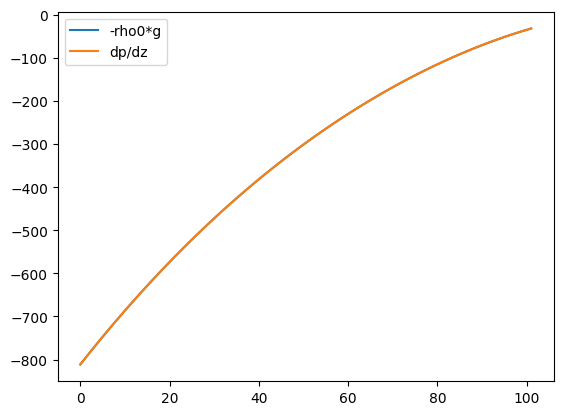

In [174]:
# test for hydrostatic equilibrium

dp_dz =(np.roll(bg['p0'], -1, axis=0)-np.roll(bg['p0'], 1, axis=0))/(2*dz)

lhs = dp_dz[1:-1]
rhs = -bg['rho0'][1:-1]*bg['g'][1:-1]


plt.plot(rhs, label="-rho0*g")
plt.plot(lhs, label="dp/dz")
#plt.plot(np.abs(lhs-rhs), label="abs difference")
plt.legend()

In [156]:
DATA_FOLDER = "/mn/stornext/d10/data/tabjone/data/"
RUN_NAME = "python_baseline_2/"

folder = DATA_FOLDER + RUN_NAME

T = 1e4 * u.s
snap = 15

# Getting initial conditions
p1, unit, _ = get_foreground_variable(folder, snap, 'p1')
p1 = p1 * u.Unit(unit)
rho1, unit, _ = get_foreground_variable(folder, snap, 'rho1')
rho1 = rho1 * u.Unit(unit)
vz, unit, _ = get_foreground_variable(folder, snap, 'vz')
vz = vz * u.Unit(unit)
s1, unit, _ = get_foreground_variable(folder, snap, 's1')
s1 = s1 * u.Unit(unit)
T1, unit, t = get_foreground_variable(folder, snap, 'T1')
T1 = T1 * u.Unit(unit)

p0, unit = get_background_variable(folder, 'p0')
p0 = p0 * u.Unit(unit)
rho0, unit = get_background_variable(folder, 'rho0')
rho0 = rho0 * u.Unit(unit)
T0, unit = get_background_variable(folder, 'T0')
T0 = T0 * u.Unit(unit)
g, unit = get_background_variable(folder, 'g')
g = g * u.Unit(unit)
grad_s0, unit = get_background_variable(folder, 'grad_s0')
grad_s0 = grad_s0 * u.Unit(unit)
r, unit = get_background_variable(folder, 'r')
r = r * u.Unit(unit)

constants_dict, global_params_dict, grid_info_dict = get_info(folder)

k_B = constants_dict['K_B'][0]
k_B = k_B * u.Unit(constants_dict['K_B'][1])
mu = constants_dict['MU'][0]
gamma = global_params_dict['GAMMA'][0]
m_u = constants_dict['M_U'][0]
m_u = m_u * u.Unit(constants_dict['M_U'][1])

c_p = k_B / (mu * m_u) /(1.0-1.0/gamma)

dz = grid_info_dict['dz'][0]
dz = dz * u.Unit(grid_info_dict['dz'][1])

# Creating dictionaries to hold variables
fg = {}
fg_prev = {}
bg = {}

# Assigning variables to dictionaries
fg['p1'] = p1
fg['rho1'] = rho1
fg['vz'] = vz
fg['s1'] = s1
fg['T1'] = T1
fg_prev['p1'] = p1
fg_prev['rho1'] = rho1
fg_prev['vz'] = vz
fg_prev['s1'] = s1
fg_prev['T1'] = T1
bg['p0'] = p0
bg['rho0'] = rho0
bg['T0'] = T0
bg['g'] = g
bg['grad_s0'] = grad_s0
bg['r'] = r

t = t * u.s

dt = np.inf

solution = []
solution.append(fg.copy())
t_list = []
t_list.append(t)


_,_,t_next = get_foreground_variable(folder, snap+1, 'T1')

dt = t_next * u.s - t
"""
while (t < T and dt > 0.1*u.s):
    dt, fg_new = rk1(fg, fg_prev, bg, dz, c_p, gamma)
    solution.append(fg_new.copy())

    fg_prev = fg.copy()
    fg = fg_new.copy()

    t += dt
    t_list.append(t)
    print(f"t={t}, dt={dt}")

"""

'\nwhile (t < T and dt > 0.1*u.s):\n    dt, fg_new = rk1(fg, fg_prev, bg, dz, c_p, gamma)\n    solution.append(fg_new.copy())\n\n    fg_prev = fg.copy()\n    fg = fg_new.copy()\n\n    t += dt\n    t_list.append(t)\n    print(f"t={t}, dt={dt}")\n\n'

In [163]:
dt, fg_new = rk1(fg_prev, bg, dz, c_p, gamma, dt)

Num iterations:  21553


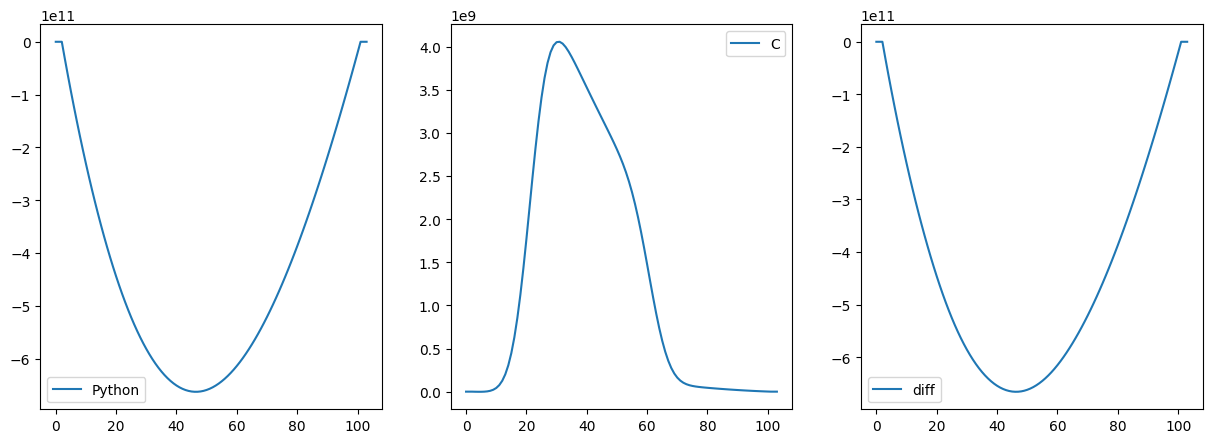

In [168]:
var_key = 'p1'

C_var, unit, _ = get_foreground_variable(folder, snap+1, var_key)
C_var = C_var * u.Unit(unit)

fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].plot(fg_new[var_key], label="Python")
ax[1].plot(C_var, label="C")
ax[2].plot(fg_new[var_key]-C_var, label="diff")

ax[0].legend()
ax[1].legend()
ax[2].legend()

In [105]:
t_list

[<Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 1653.84653673 s>,
 <Quantity 165

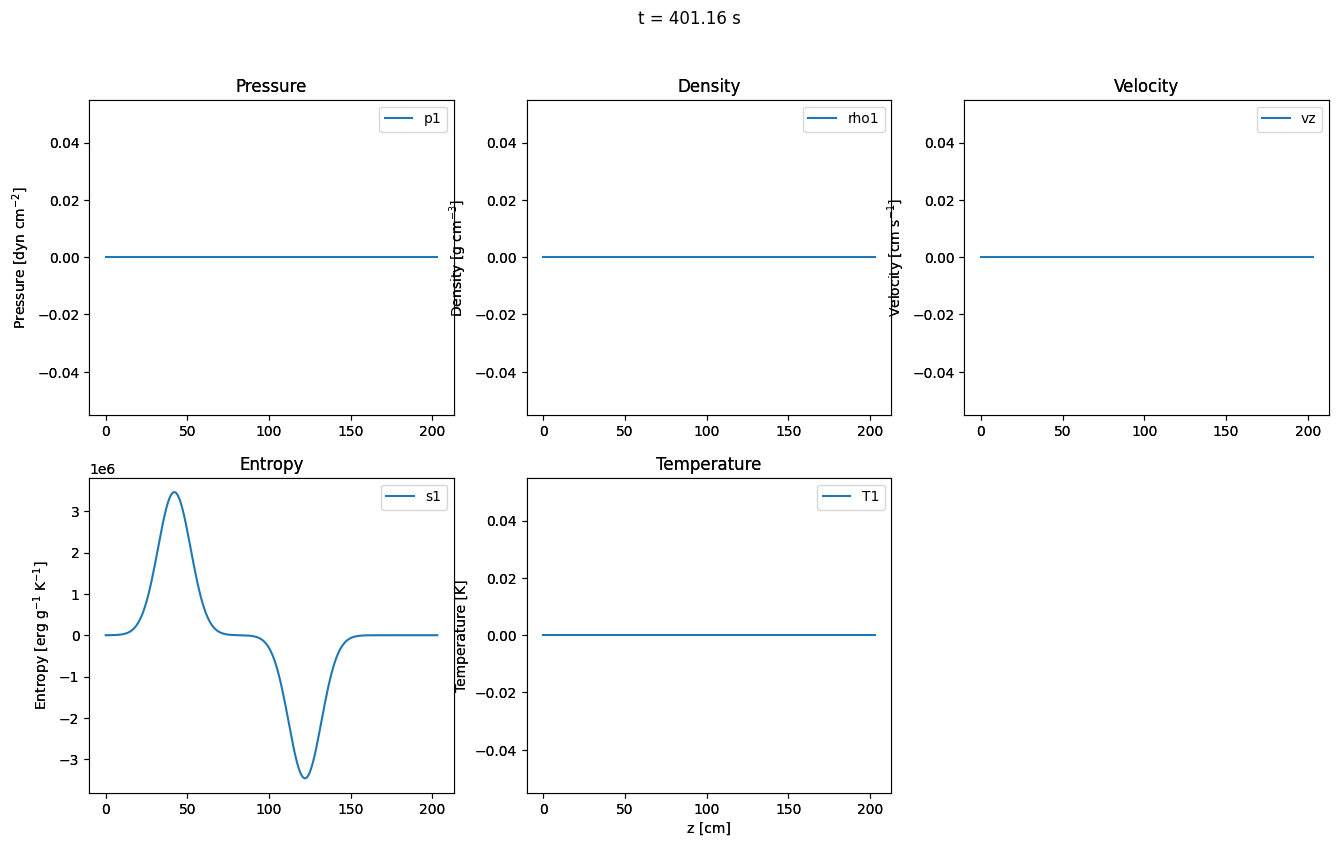

In [108]:
def plot_all_vars(fig, solution, t_list, timestep):
    ax1 = fig.add_subplot(2, 3, 1)
    ax2 = fig.add_subplot(2, 3, 2, sharex=ax1)
    ax3 = fig.add_subplot(2, 3, 3, sharex=ax1)
    ax4 = fig.add_subplot(2, 3, 4, sharex=ax1)
    ax5 = fig.add_subplot(2, 3, 5, sharex=ax1)

    ax1.plot(solution[timestep]['p1'], label="p1")
    ax1.set_title("Pressure")
    ax1.set_ylabel("Pressure [dyn cm$^{-2}$]")
    ax1.legend()

    ax2.plot(solution[timestep]['rho1'], label="rho1")
    ax2.set_title("Density")
    ax2.set_ylabel("Density [g cm$^{-3}$]")
    ax2.legend()

    ax3.plot(solution[timestep]['vz'], label="vz")
    ax3.set_title("Velocity")
    ax3.set_ylabel("Velocity [cm s$^{-1}$]")
    ax3.legend()

    ax4.plot(solution[timestep]['s1'], label="s1")
    ax4.set_title("Entropy")
    ax4.set_ylabel("Entropy [erg g$^{-1}$ K$^{-1}$]")
    ax4.legend()

    ax5.plot(solution[timestep]['T1'], label="T1")
    ax5.set_title("Temperature")
    ax5.set_ylabel("Temperature [K]")
    ax5.legend()

    ax5.set_xlabel("z [cm]")

    fig.suptitle(f"t = {t_list[timestep].value:.2f} {t_list[timestep].unit}")


def animate_all_vars(solution, t_list):

    fig = plt.figure(figsize=(16, 9))  # Create a figure

    def init_animation():
        plot_all_vars(fig, solution, t_list, 0)

    def update_animation(timestep):
        """Update the plots for each frame."""
        for ax in fig.get_axes():
            ax.clear()  # Clear previous data
        fig.clear()
        plot_all_vars(fig, solution, t_list, timestep)

    anim = FuncAnimation(fig, update_animation, interval=1, frames=range(0,len(solution)-3000, 3), init_func=init_animation)

    anim.save("data/test_2.mp4", writer='ffmpeg', fps=15, extra_args=['-vcodec', 'libx264'])

animate_all_vars(solution, t_list)

In [91]:
len(solution)

90

In [ ]:
def plot_solution(solution, timestep):
    plt.figure(figsize=(10,10))
    plt.plot(solution[timestep]['vz'], solution[timestep]['r'])
    plt.xlabel("vz")
    plt.ylabel("r")
    plt.show()

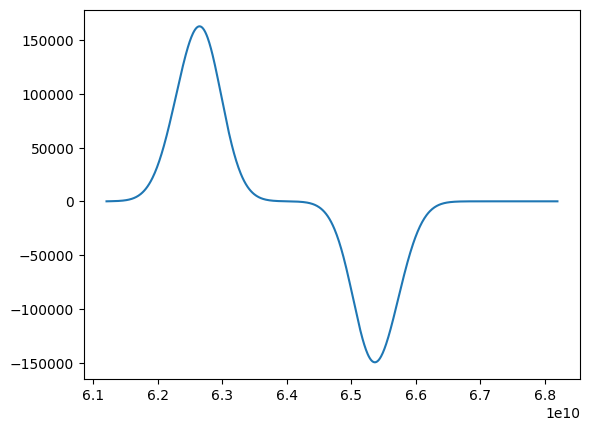

In [90]:
plt.plot(r, solution[-1]['vz'])

Num iterations:  1


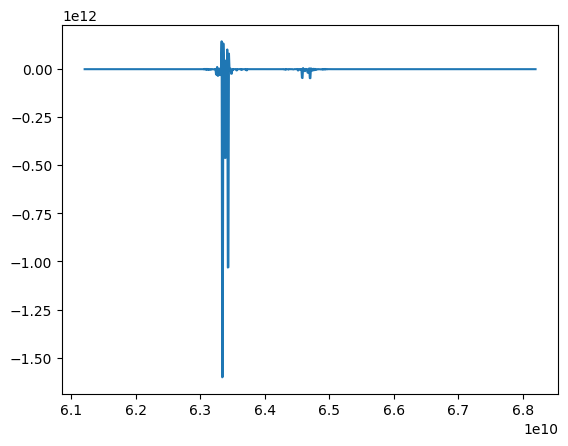

In [43]:
plt.plot(r, fg['p1'])

In [41]:
fg['vz'].dtype

dtype('<f8')

Num iterations:  1


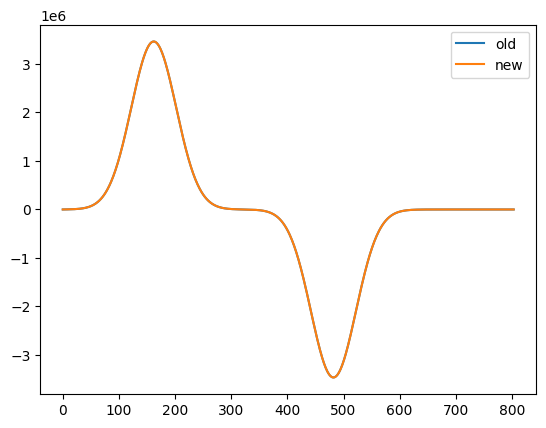

In [32]:
_, fg_new = rk1(fg, fg_prev, bg, dz, c_p, gamma)

plt.plot(fg['s1'], label='old')
plt.plot(fg_new['s1'], label='new')
plt.legend()

In [178]:
def damping(zb_top, r_i, z0_top, alpha):
    return ((zb_top-r_i)/(zb_top-z0_top))**alpha

In [207]:
top_r = 0.98
bottom_r = 0.88
SOFT_WALL_HEIGHT_PERCENTAGE_VERTICAL = 0.2
damped_domain = (top_r - bottom_r) * SOFT_WALL_HEIGHT_PERCENTAGE_VERTICAL
z0_bot = bottom_r + damped_domain
z0_top = top_r - damped_domain
zb_bot = 0.88
zb_top = 0.98

In [223]:
z0_bot

0.9

In [239]:
np.where(damping(4)!=1)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

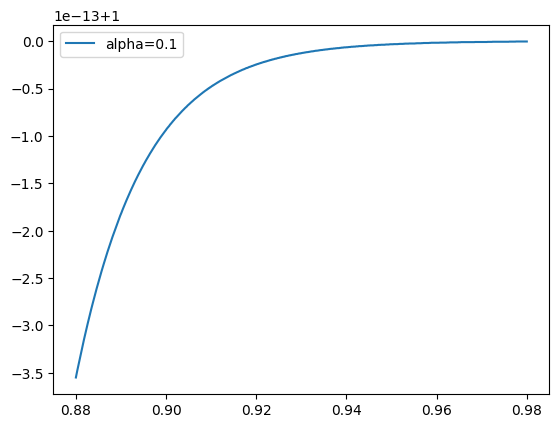

In [238]:
def damping(k):
    #damping_factor = np.ones(len(r))
    damping_factor = (np.tanh((r - z0_bot/2)/0.03) + 1.0)/2


    return damping_factor


r = np.linspace(bottom_r, top_r, 1000)

#-2.0 / (1.0 + exp(-1.5*(i - nz_ghost - nz))) + 1.0

plt.plot(r, damping(4), label="alpha=0.1")
#plt.plot(r, damping(0.5), label="alpha=0.5")
#plt.plot(r, damping(0.8), label="alpha=0.8")
plt.legend()
damping(4)